In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# import missingno as msno
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
# Read the data
raw_data = pd.read_csv('../../data/LC_train.csv')

# Convert dates and times to appropriate formats
lc_data = raw_data.copy()
lc_data['Check_In_Date'] = pd.to_datetime(lc_data['Check_In_Date'])
lc_data['Check_In_Time'] = pd.to_datetime(lc_data['Check_In_Time']).dt.time
lc_data['Check_Out_Time'] = pd.to_datetime(lc_data['Check_Out_Time']).dt.time

/tmp/ipykernel_542/1977943083.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lc_data['Check_In_Date'] = pd.to_datetime(lc_data['Check_In_Date'])
/tmp/ipykernel_542/1977943083.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lc_data['Check_In_Time'] = pd.to_datetime(lc_data['Check_In_Time']).dt.time
/tmp/ipykernel_542/1977943083.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lc_data['Check_Out_Time'] = pd.to_datetime(lc_data['Check_Out_Time']).dt.time


In [5]:
# Sort and calculate occupancy
lc_data = lc_data.sort_values(['Check_In_Date', 'Check_In_Time']).reset_index(drop=True)

def calculate_occupancy(df):
    results = []
    
    # Process each date group
    for date, group in df.groupby('Check_In_Date'):
        check_in_times = pd.to_datetime(group['Check_In_Time'].astype(str)).dt.time
        check_out_times = pd.to_datetime(group['Check_Out_Time'].astype(str)).dt.time
        
        n = len(group)
        cum_arrivals = list(range(n))  # Equivalent to row_number() - 1
        
        # Calculate cumulative departures
        cum_departures = []
        for i in range(n):
            departures = sum(
                1 for j in range(i)
                if not pd.isna(check_out_times.iloc[j]) and 
                check_out_times.iloc[j] <= check_in_times.iloc[i]
            )
            cum_departures.append(departures)
        
        # Calculate occupancy
        occupancy = [a - d for a, d in zip(cum_arrivals, cum_departures)]
        
        # Store results for this group
        group_results = pd.DataFrame({
            'Cum_Arrivals': cum_arrivals,
            'Cum_Departures': cum_departures,
            'Occupancy': occupancy
        }, index=group.index)
        
        results.append(group_results)
    
    # Combine all results
    return pd.concat(results)

# Calculate occupancy metrics
occupancy_metrics = calculate_occupancy(lc_data)
lc_data = pd.concat([lc_data, occupancy_metrics], axis=1)

/tmp/ipykernel_542/2514663713.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  check_in_times = pd.to_datetime(group['Check_In_Time'].astype(str)).dt.time
/tmp/ipykernel_542/2514663713.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  check_out_times = pd.to_datetime(group['Check_Out_Time'].astype(str)).dt.time
/tmp/ipykernel_542/2514663713.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  check_in_times = pd.to_datetime(group['Check_In_Time'].astype(str)).dt.time
/tmp/ipykernel_542/2514663713.py:10: UserWarning: Could not infer format, so each element will be parse

In [6]:
lc_data

,Student_IDs,Semester,Degree_Type,Class_Standing,Major,Expected_Graduation,Course_Name,Course_Number,Course_Type,Course_Code_by_Thousands,...,Duration_In_Min,Gender,Term_Credit_Hours,Term_GPA,Total_Credit_Hours_Earned,Cumulative_GPA,Change_in_GPA,Cum_Arrivals,Cum_Departures,Occupancy
0,BGSU02770,Fall 2016,Undergraduate,Senior,"BLS-BLS:Liberal Studies,BLSOL:BLS On Line Degr...",Spring Semester 2020,Precalculus Mathematics,MATH-1280,MATH,1000,...,106,MALE,12,2.250,136.0,2.720,-0.470,0,0,0
1,BGSU02020,Fall 2016,Undergraduate,Senior,"MIS-BSBA:Information Systems,SUPC-BSBA:Supply ...",Spring Semester 2020,Business Analytics III: Descriptive Analytics,STAT-2110,STAT,2000,...,45,MALE,16,2.312,131.0,2.562,-0.250,1,0,1
2,BGSU00467,Fall 2016,Undergraduate,Senior,No Response,Summer Semester 2018,College Algebra,MATH-1220,MATH,1000,...,96,MALE,17,3.000,148.0,2.812,0.188,2,2,0
3,BGSU02909,Fall 2016,Undergraduate,Senior,MCED-BSED:Middle Childhood Education,Spring Semester 2021,Precalculus Mathematics,MATH-1280,MATH,1000,...,68,FEMALE,21,3.562,150.0,3.633,-0.071,3,2,1
4,BGSU03838,Fall 2016,Undergraduate,Senior,"COMPSC-BA:Computer Science,ENTREP-MIN:Entrepre...",Fall Semester 2020,Elementary Algebra,MATH-90X,MATH,99,...,89,MALE,15,3.000,119.0,3.105,-0.105,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11730,BGSU03937,Spring 2017,Undergraduate,Senior,IPC-BAC:Communication,Spring Semester 2021,Intermediate Algebra,MATH-95X,MATH,99,...,54,MALE,14,2.357,116.0,2.336,0.021,13,12,1
11731,BGSU02743,Spring 2017,Undergraduate,Sophomore,"SCIENC-MIN:Science,STAT-BS:Statistics",Spring Semester 2018,Calculus and Analytic Geometry,MATH-1310,MATH,1000,...,83,MALE,15,3.266,51.0,2.627,0.639,0,0,0
11732,BGSU00496,Spring 2017,Undergraduate,Senior,No Response,Spring Semester 2018,Introduction to Statistics,MATH-1150,MATH,1000,...,35,MALE,15,2.000,125.0,2.131,-0.131,1,0,1
11733,BGSU00294,Spring 2017,Undergraduate,Senior,No Response,Fall Semester 2017,Fundamentals of Statistics,MATH-2470,MATH,2000,...,9,MALE,15,3.000,128.0,3.094,-0.094,2,0,2


In [7]:
# Basic overview of the data
print("Data Overview:")
print(lc_data.info())
print("\nSummary Statistics:")
print(lc_data.describe())

# Check for missing values
missing_values = lc_data.isnull().sum()
print("\nMissing values by column:")
print(missing_values[missing_values > 0])

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11735 entries, 0 to 11734
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Student_IDs                11735 non-null  object        
 1   Semester                   11735 non-null  object        
 2   Degree_Type                11735 non-null  object        
 3   Class_Standing             11735 non-null  object        
 4   Major                      11735 non-null  object        
 5   Expected_Graduation        11735 non-null  object        
 6   Course_Name                11735 non-null  object        
 7   Course_Number              11735 non-null  object        
 8   Course_Type                11735 non-null  object        
 9   Course_Code_by_Thousands   11735 non-null  int64         
 10  Semester_Week              11735 non-null  int64         
 11  Check_In_Date              11735 non-null  datetime6

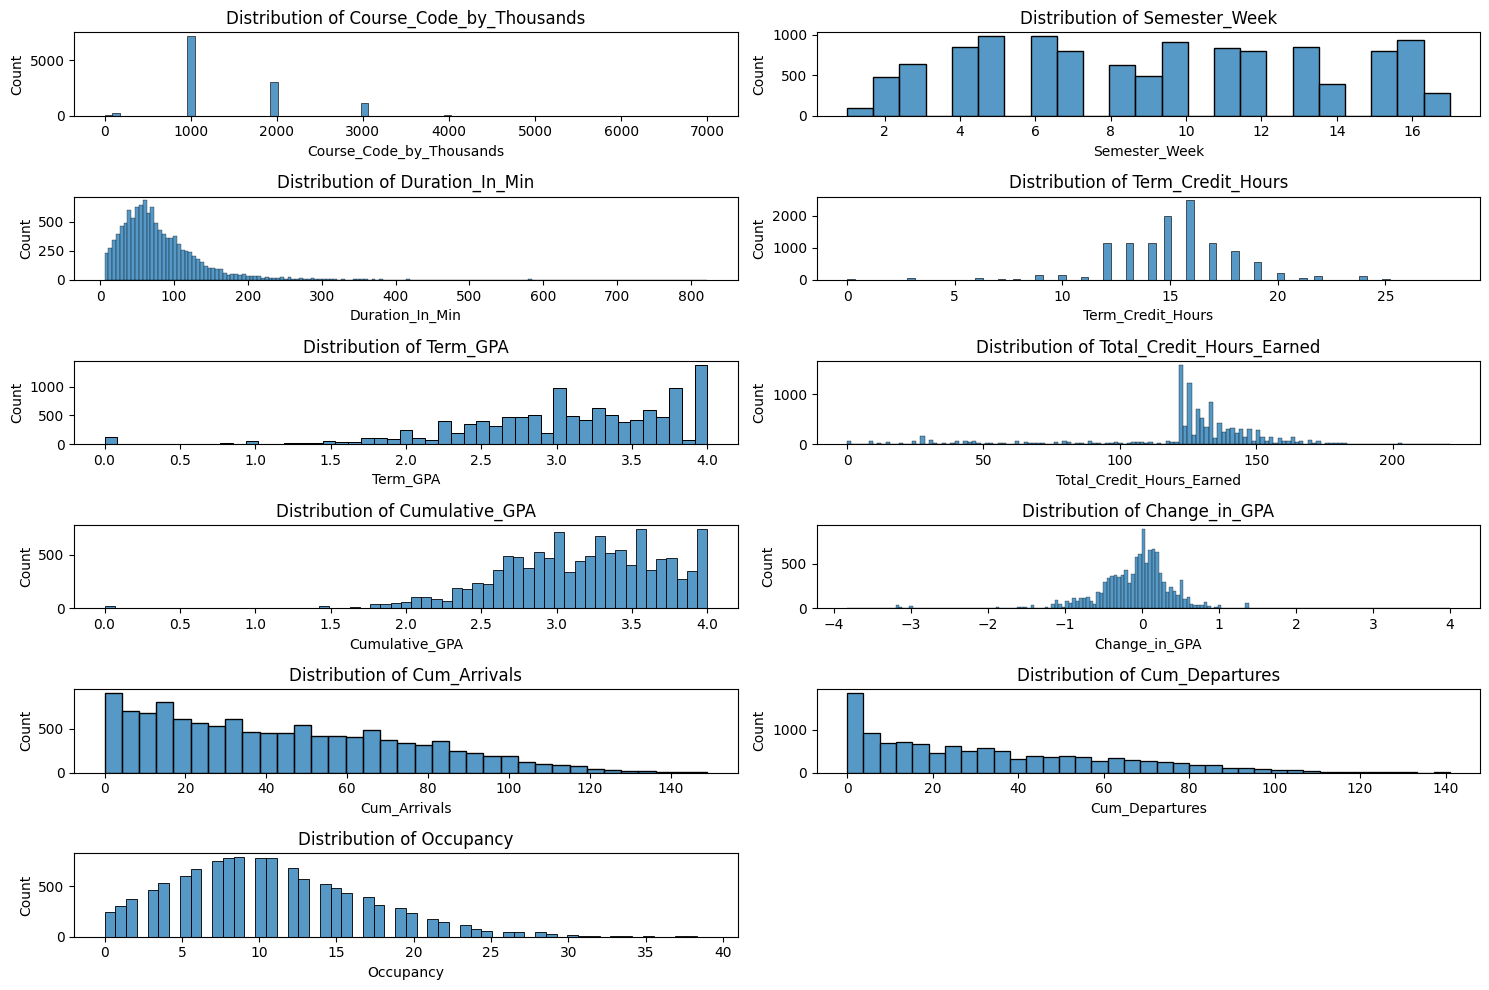

In [8]:
# Visualizations
plt.figure(figsize=(15, 10))

# Distribution plots for numeric columns
numeric_cols = lc_data.select_dtypes(include=[np.number]).columns
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//2 + 1, 2, i)
    sns.histplot(data=lc_data, x=col)
    plt.title(f'Distribution of {col}')
plt.tight_layout()

/tmp/ipykernel_542/2806484627.py:9: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


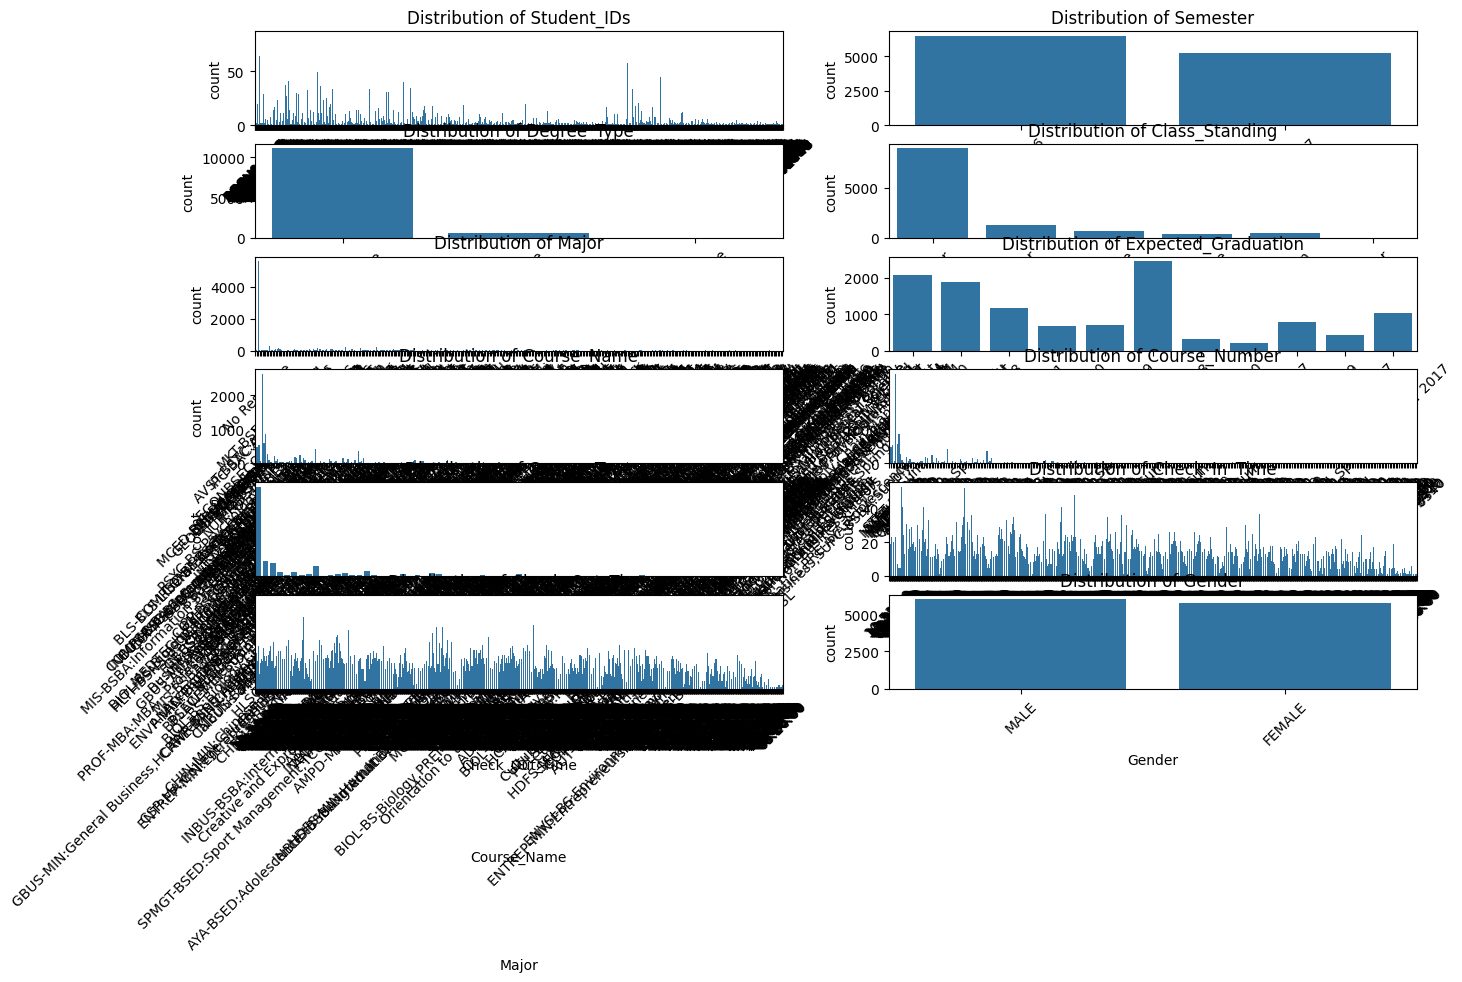

In [9]:
# Categorical plots
plt.figure(figsize=(15, 10))
categorical_cols = lc_data.select_dtypes(include=['object']).columns
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols)//2 + 1, 2, i)
    sns.countplot(data=lc_data, x=col)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
plt.tight_layout()

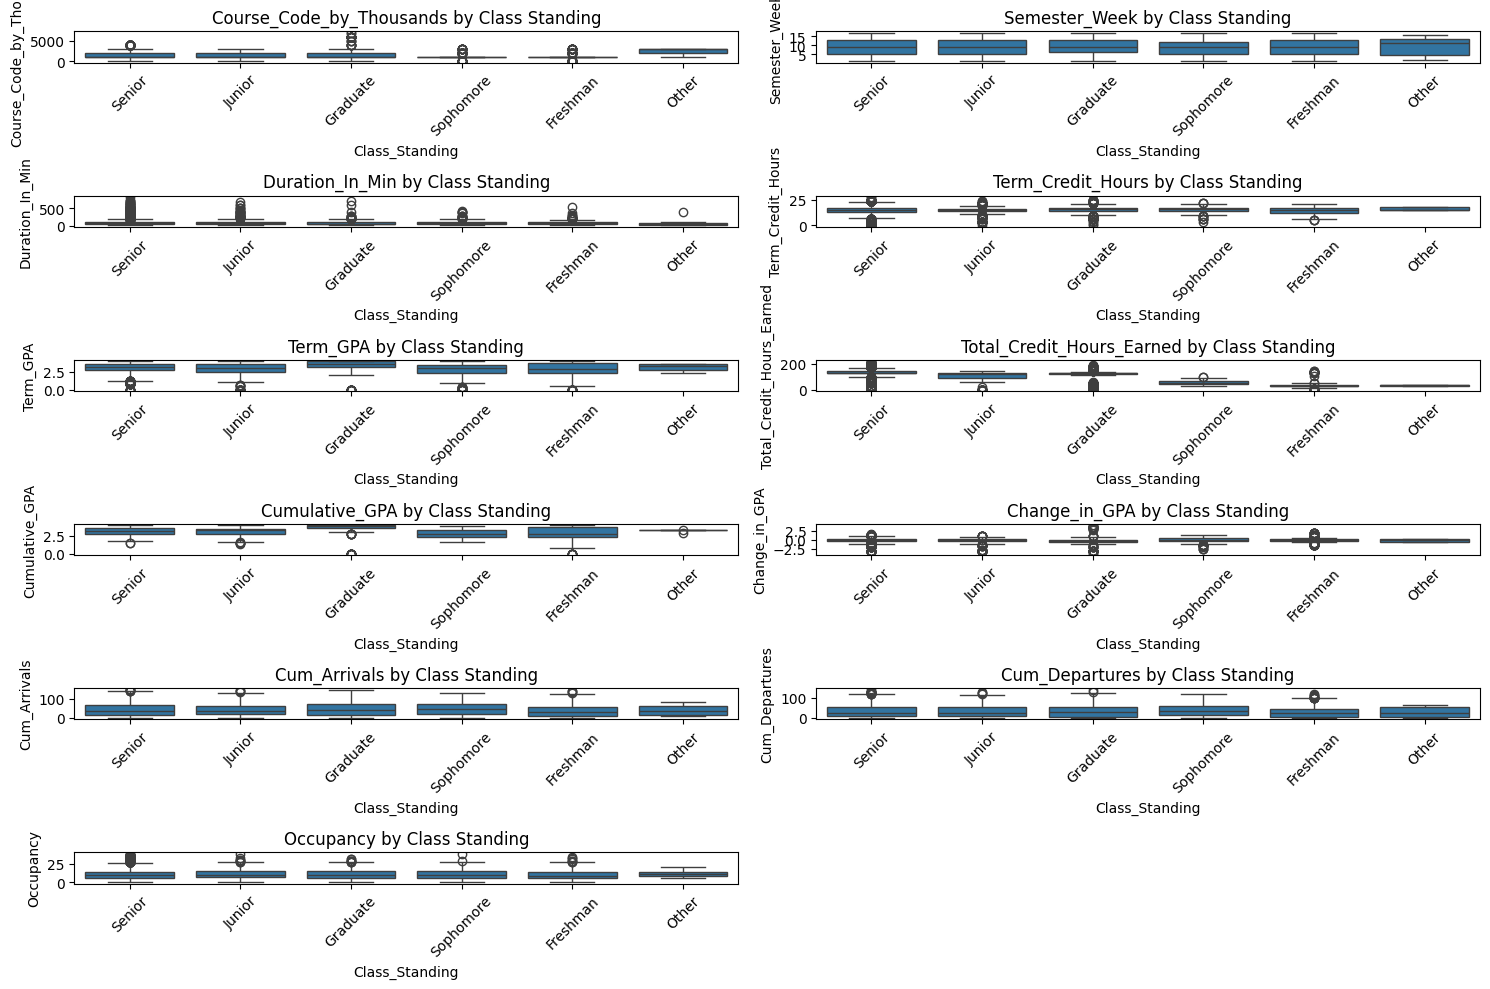

In [10]:
# Box plots by Class Standing
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//2 + 1, 2, i)
    sns.boxplot(data=lc_data, x='Class_Standing', y=col)
    plt.xticks(rotation=45)
    plt.title(f'{col} by Class Standing')
plt.tight_layout()

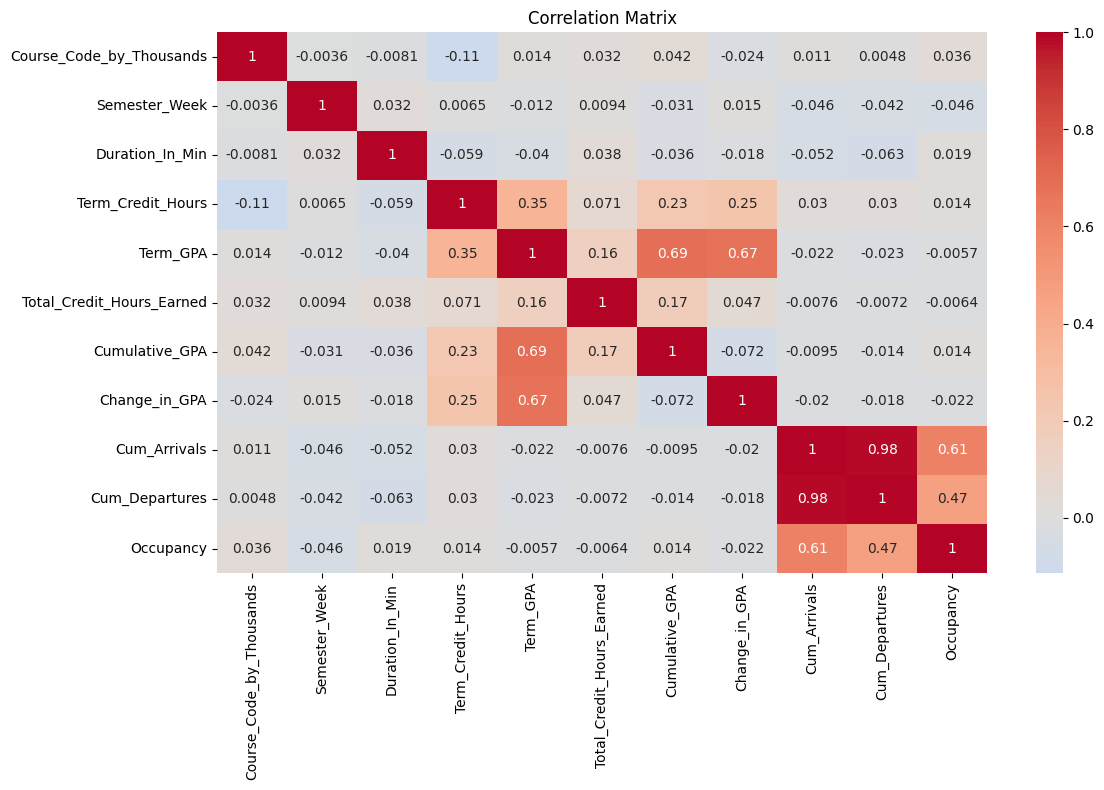

In [11]:
# Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = lc_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()

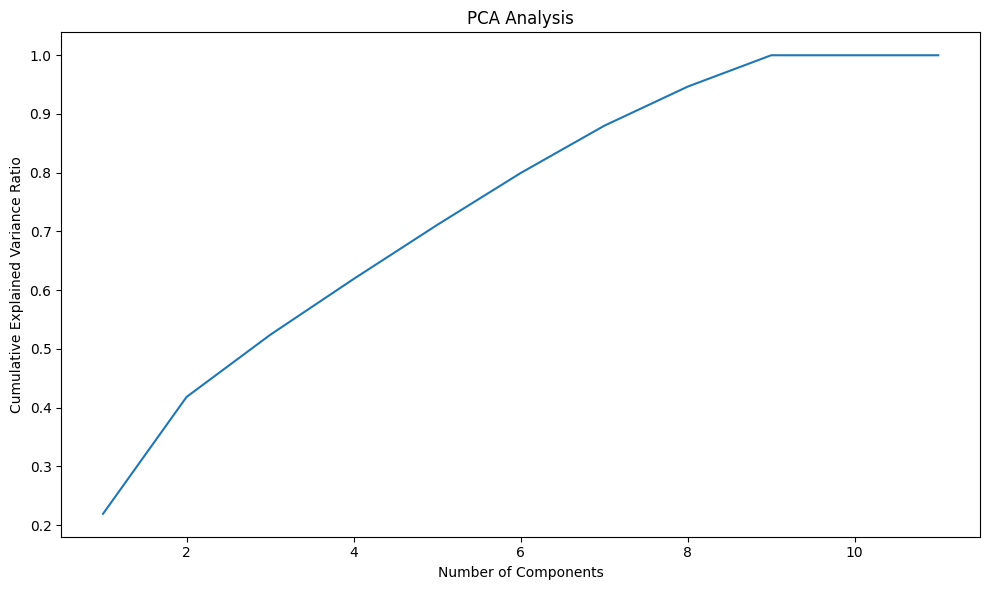

In [12]:
# PCA Analysis
numeric_data = lc_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Analysis')
plt.tight_layout()

In [14]:
# Read and analyze engineered data
engineered_data = pd.read_csv('../../data/LC_engineered.csv')

print("\nEngineered Data Overview:")
print(engineered_data.info())
print("\nEngineered Data Summary Statistics:")
print(engineered_data.describe())


Engineered Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11735 entries, 0 to 11734
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_IDs                   11735 non-null  object 
 1   Semester                      11735 non-null  object 
 2   Degree_Type                   11735 non-null  object 
 3   Class_Standing                11735 non-null  object 
 4   Major                         11735 non-null  object 
 5   Expected_Graduation           11735 non-null  object 
 6   Course_Name                   11735 non-null  object 
 7   Course_Number                 11735 non-null  object 
 8   Course_Type                   11735 non-null  object 
 9   Course_Code_by_Thousands      11735 non-null  int64  
 10  Semester_Week                 11735 non-null  int64  
 11  Check_In_Date                 11735 non-null  object 
 12  Check_In_Time                 117